In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../welddb/welddb_cleaned_for_pca.csv')

### Handle Missing Values for Charpy Impact Toughness Target

Remove columns unrelated to Charpy impact toughness or representing other target variables:

In [3]:
# drop all other target columns
target_variable = 'Charpy impact toughness (J)'

df = df.drop(columns=['Yield strength (MPa)', 'Ultimate tensile strength (MPa)',
       'Elongation (%)', 'Charpy temperature (deg C)',
       'Reduction of Area (%)', 'Hardness (kgmm-2)', '50 % FATT',
       'Primary ferrite in microstructure (%)',
       'Ferrite with second phase (%)', 'Acicular ferrite (%)',
       'Martensite (%)', 'Ferrite with carbide aggregate (%)','Puissance (W)'])


In [4]:
# Filter the dataset to include only rows where 'Yield strength (MPa)' is not missing
df_charpy_toughness = df[df[target_variable].notna()]

# Check the shape of the dataset after filtering
df_charpy_toughness.shape

(879, 39)

In [5]:
# Count the number of missing values in each column before the imputation
missing_values_before_imputation = df_charpy_toughness.isnull().sum()
missing_values_before_imputation = missing_values_before_imputation[missing_values_before_imputation > 0]

# Display the columns that had missing values and their counts
missing_values_before_imputation

Series([], dtype: int64)

In [6]:
from sklearn.experimental import enable_iterative_imputer  # Required for Iterative Imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge  # Importer BayesianRidge

# Initialize the Iterative Imputer
iterative_imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None,
                           imputation_order='ascending', random_state=42)
# Apply the iterative imputer on the dataset (excluding the target 'Yield strength (MPa)')
df_features = df_charpy_toughness.drop(columns=[target_variable])
df_imputed_iterative = pd.DataFrame(iterative_imputer.fit_transform(df_features), columns=df_features.columns)

# Add back the target 'Yield strength (MPa)'
df_imputed_iterative[target_variable] = df_charpy_toughness[target_variable].values

# Display the first few rows of the imputed dataset
df_imputed_iterative.head()


,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Type of weld_GMAA,Type of weld_GTAA,Type of weld_MMA,Type of weld_NGGMA,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA,Charpy impact toughness (J)
0,-1.612394,-0.254200,-1.447095,-0.136415,-0.048693,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
1,-1.612394,-0.254200,-1.447095,-0.136415,-0.048693,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,-1.612394,-0.165249,-0.452386,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
3,-1.612394,-0.165249,-0.452386,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,-1.319395,0.190556,0.594677,-0.225627,0.053550,-0.318155,-0.427452,-0.56357,-0.146903,-0.289924,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


### XgBoost training

In [7]:
df1 = df_imputed_iterative.copy()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer,root_mean_squared_error
from xgboost import XGBRegressor, plot_importance


In [9]:
# Séparer les features et la target
X = df1.drop(columns=[target_variable])
y = df1[target_variable]
# Séparer en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
def evaluate_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, r2

In [11]:
model = XGBRegressor(
    random_state=42,
    reg_lambda=1,   # L2 regularization term (lambda)
    reg_alpha=1,    # L1 regularization term (alpha)
    learning_rate=0.05,   # Lower learning rate for better generalization
    n_estimators=500,     # The maximum number of estimators
    max_depth=5,          # Moderate max depth to avoid overfitting
    eval_metric="rmse",   # Set the evaluation metric here in the constructor
)

In [12]:
# Définir les scorers
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': 'r2'
}

In [13]:
# Hyperparameter tuning
xgb_params = {
    'reg_lambda': [0.01, 0.1, 1, 10],
    'reg_alpha': [0.01, 0.1, 1, 10],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

In [14]:
results = {
    'Model': [],
    'Best Parameters': [],
    'Test MSE': [],   # Add 'Test MSE' key
    'Test RMSE': [],  # Add 'Test RMSE' key
    'Test MAE': [],   # Add 'Test MAE' key
    'Test R²': []
}

In [15]:

grid_search = GridSearchCV(estimator=model, param_grid=xgb_params, 
                           cv=5, scoring=scoring, refit='R2', return_train_score=True)
grid_search.fit(X_train, y_train)
# Best parameters and predictions
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Enregistrer les paramètres optimaux



test_mse, test_rmse, test_mae, test_r2 = evaluate_metrics(y_test, y_pred)
results['Model'].append(best_model)  # Append the model
results['Best Parameters'].append(best_params)  # Append best parameters
results['Test MSE'].append(test_mse)  # Append MSE
results['Test RMSE'].append(test_rmse)  # Append RMSE
results['Test MAE'].append(test_mae)  # Append MAE
results['Test R²'].append(test_r2)  # Append R²
# Convertir les résultats en DataFrame

for key, value in results.items():
    print(f"Length of {key}: {len(value)}")

results_df = pd.DataFrame(results)

# Afficher le DataFrame des résultats
results_df

Length of Model: 1
Length of Best Parameters: 1
Length of Test MSE: 1
Length of Test RMSE: 1
Length of Test MAE: 1
Length of Test R²: 1


,Model,Best Parameters,Test MSE,Test RMSE,Test MAE,Test R²
0,"XGBRegressor(base_score=None, booster=None, ca...","{'learning_rate': 0.01, 'max_depth': 3, 'reg_a...",2100.17295,45.827644,35.973069,0.245022


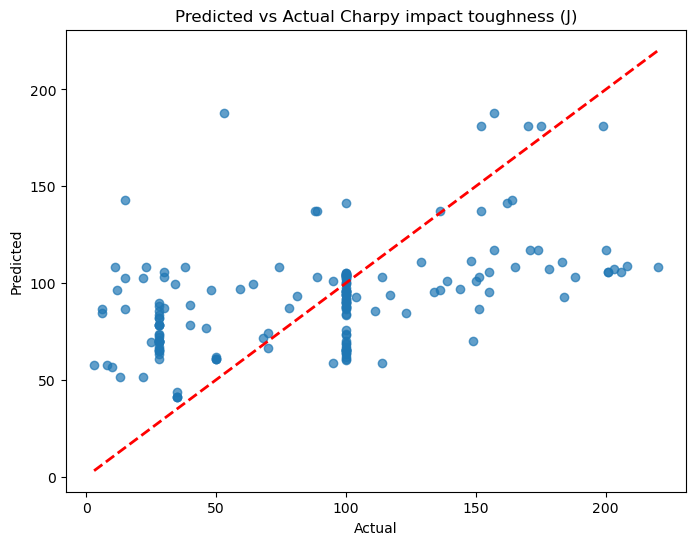

In [16]:
# Plot the predicted vs actual values

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual {target_variable}')
plt.show()


<Figure size 1000x800 with 0 Axes>

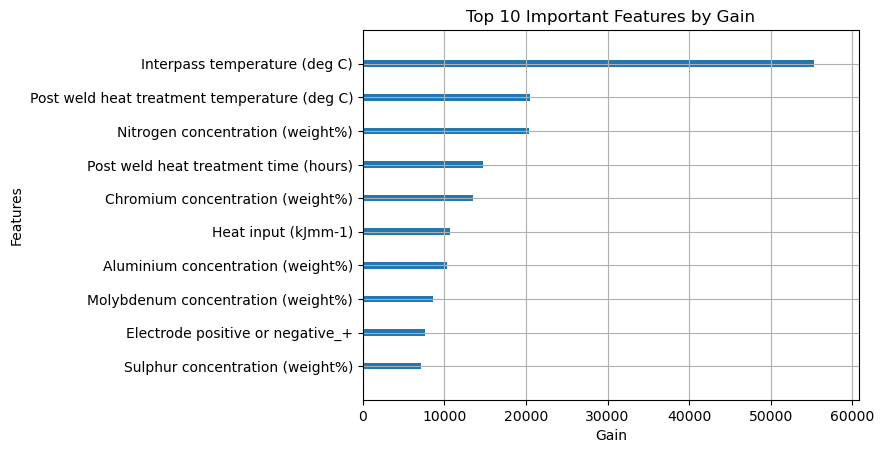

Top 10 Important Features:
Interpass temperature (deg C): 55293.12890625
Post weld heat treatment temperature (deg C): 20547.15234375
Nitrogen concentration (weight%): 20406.947265625
Post weld heat treatment time (hours): 14771.9130859375
Chromium concentration (weight%): 13446.83203125
Heat input (kJmm-1): 10664.75
Aluminium concentration (weight%): 10273.1650390625
Molybdenum concentration (weight%): 8555.841796875
Electrode positive or negative_+: 7618.81591796875
Sulphur concentration (weight%): 7158.44189453125


In [19]:
# Plot the feature importance with feature names
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='gain', max_num_features=10, show_values=False, xlabel="Gain")
plt.title('Top 10 Important Features by Gain')
plt.show()
# Get the list of the high important features
important_features = best_model.get_booster().get_score(importance_type='gain')
important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Create a list of the top 10 important features
top_10_features = [feature for feature, importance in important_features[:10]]
print("Top 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance}")

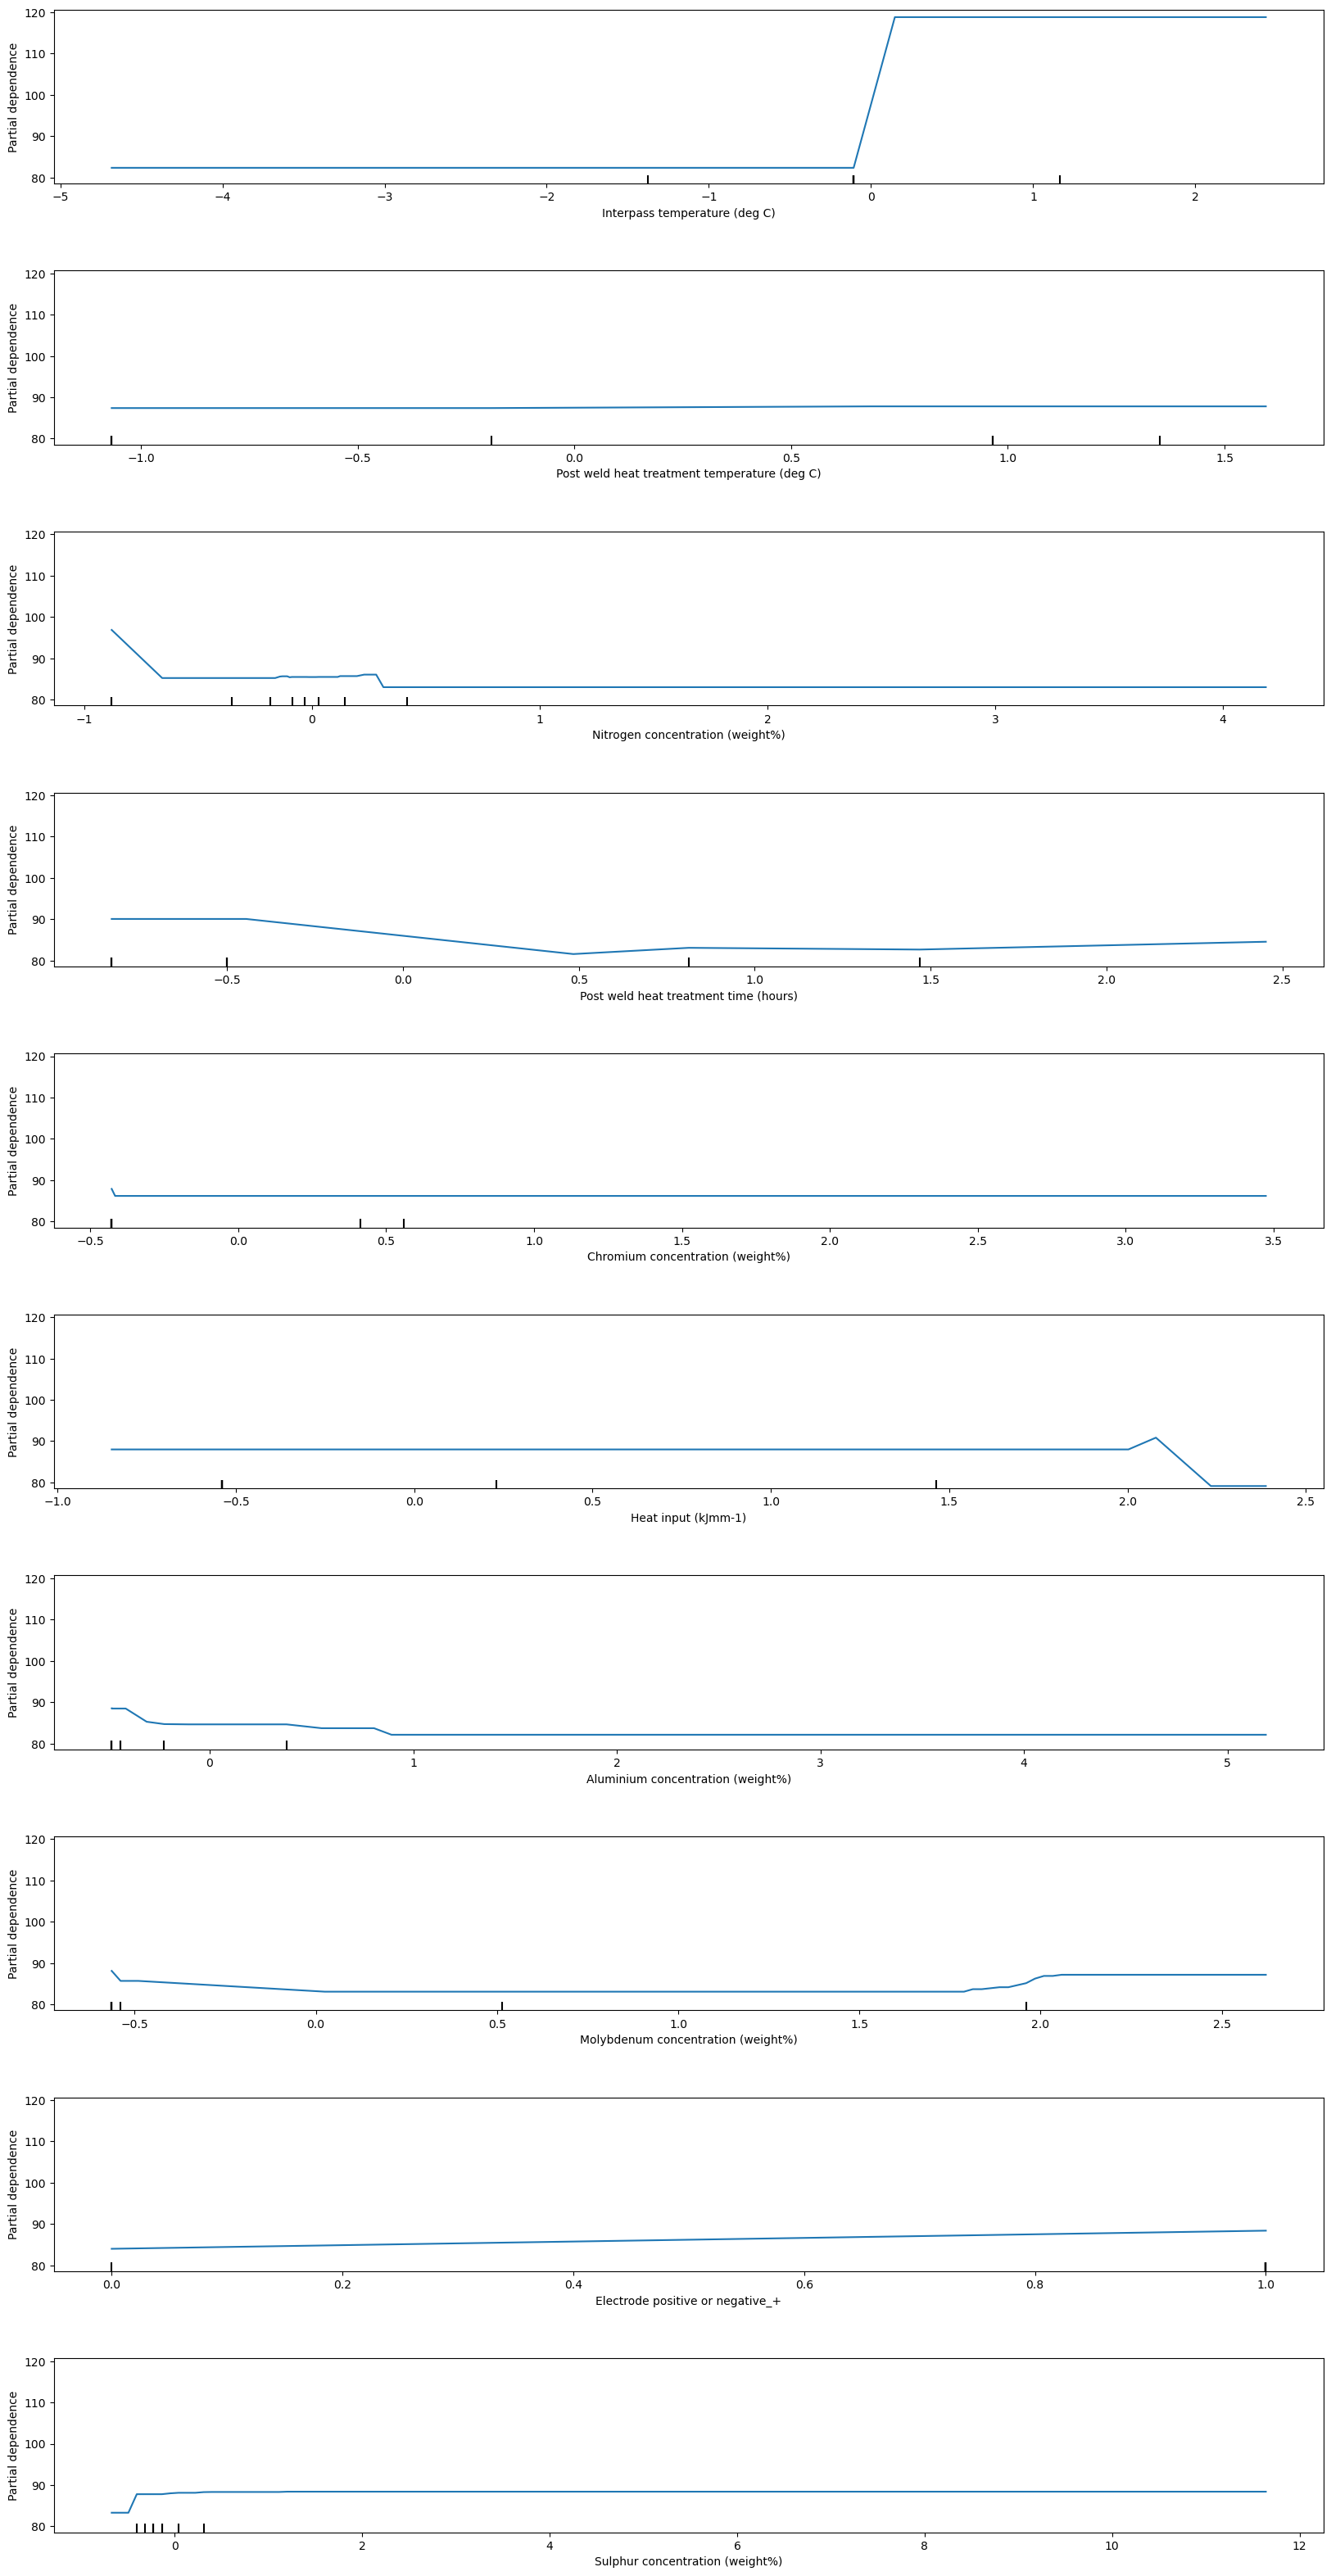

In [20]:
from sklearn.inspection import PartialDependenceDisplay

# Increase figure size and adjust layout to make it clearer
fig, ax = plt.subplots(len(top_10_features), 1, figsize=(20, 40))  # Separate each feature into its own row for better clarity

# Generate partial dependence plots
display = PartialDependenceDisplay.from_estimator(
    best_model, X_train, top_10_features, ax=ax
)

plt.subplots_adjust(hspace=0.5)  # Add more spacing between the plots
plt.show()


c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "xgb__learning_rate", "xgb__max_depth"

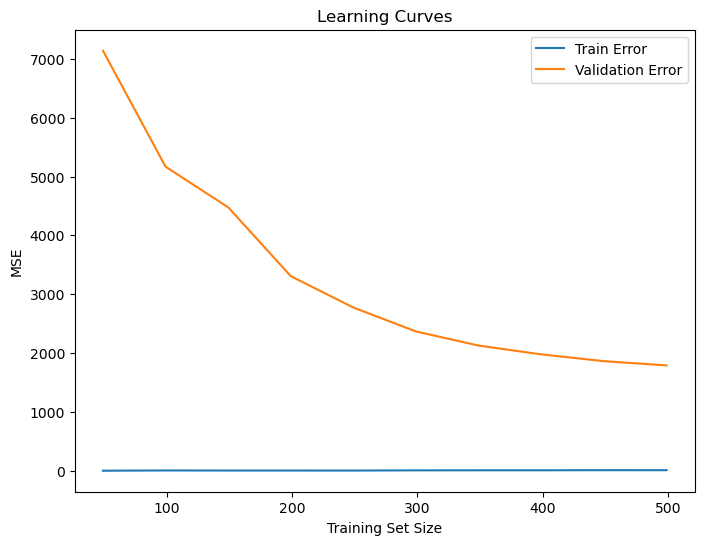

In [90]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10))

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Train Error')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()


- The training error (blue line) is flat and near zero, which typically indicates that the model fits the training data almost perfectly. This suggests that the model is not underfitting on the training data. It is learning the patterns in the training set quite well, which is generally a good sign.

- The model is performing very well on the training data but is likely overfitting, as indicated by the large gap between the training and validation errors.

- Given that the training error is near zero while the validation error is high, the model may be too complex for the available data. Techniques such as regularization (e.g., increasing lambda or alpha in XGBoost) or early stopping could help reduce overfitting by simplifying the model